
# PS2: Mini-batch SGD, CNN, and RNN

Advanced Learning 2025/6.



For SUBMISSION:   

Please upload the complete and executed `ipynb` to your git repository. Verify that all of your output can be viewed directly from github, and provide a link to that git file below.

~~~
STUDENT ID: 308577469
~~~

~~~
STUDENT GIT LINK: https://github.com/guyshiff-school/Adv_computational_learning_and_data_analysis
~~~
In Addition, don't forget to add your ID to the files, and upload to moodle the html version:    
  
`PS2_CNN_RNN_2024_ID_[000000000].html`   




---


Imports:

In [1]:
import numpy as np # You are allowed to use  only numpy.
import time, sys, cProfile
import matplotlib.pyplot as plt

Please import the objects in `src.py` file into the workspace

In [5]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [6]:
your_drive_path_to_src_file = "/content/drive/MyDrive/shanaB_learning/"
sys.path.append(your_drive_path_to_src_file)

In [7]:
from src import *

Note that now all of the network's objects from PS1 are loaded into the workspace.

Alternatively, you can upload src.py in the files tab found on the left hand side if you are using colab.

---

### 0. Loading data

As in PS1, you will evaluate your home-made network on the `mnist` dataset.   
The MNIST dataset is a large dataset of handwritten digits that is commonly used for training various image and vision models.  



In [8]:
from keras.datasets import mnist
from keras.utils import to_categorical
# load MNIST from server
# Using a standard library (keras.datasets) to load the mnist data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## PS2 Part 1: Mini-batch SGD



**Welcome back**.   






Mini-batch Stochastic Gradient Descent (Mini-batch SGD) is an optimization algorithm used to train machine learning models, particularly neural networks. It strikes a balance between two other methods:

    Batch Gradient Descent – Uses the entire dataset to compute gradients and update the model parameters.
        ✅ Accurate gradients
        ❌ Slow and memory-intensive for large datasets

    Stochastic Gradient Descent (SGD) – Uses a single data point to compute gradients for each update.
        ✅ Fast and efficient
        ❌ Noisy updates, which can lead to instability

  
**Mini-batch SGD**.

Mini-batch SGD computes gradients and updates the model parameters using small, randomly selected batches of data (typically 32, 64, or 128 samples).

    ✅ Faster than batch gradient descent
    ✅ Less noisy than pure SGD
    ✅ Efficient use of memory
    ✅ Enables vectorization for faster computation on GPUs

**How it Works**.

    Shuffle the dataset to avoid bias.

    Divide the data into small batches (e.g., 64 samples per batch).

    For each epoch, iterate through the mini-batches:
        Perform forward pass to calculate predictions.
        Compute the loss for the mini-batch.
        Perform backpropagation to compute gradients.
        Update model parameters using the gradients.

    Repeat until the model converges.

**Algorithm**

For each mini-batch $B={x_1,x_2,...,x_m}B={x_1​,x_2​,...,x_m​}$ of size $m$, update the weights $w$ as:    

$$
w=w−η⋅\frac{1}{m}∑_{i=1}^m ∇L(w,x_i)
$$

Where:   
*  $η$ = learning rate.
* $∇L(w,x_i)$ = gradient of the loss for sample $x_i$.   

Advantages

    Efficient and scalable – Works well with large datasets.
    Smooth convergence – Less noisy than SGD but faster than full batch training.
    Parallelization – Batches can be processed in parallel on GPUs.

Disadvantages

    Choosing batch size can affect performance. Small batches lead to noise, large batches consume more memory.
    Convergence may be slower than batch gradient descent for some problems.


### Mini-batch Questions.
**P1Q1**:  

Please answer the following questions providing statistical justifications and mathematical formulas when needed.

P1Q1a: Explain how the mini-batch size impacts convergence, model performance, and computational efficiency.



Smaller batches give noisier gradients that help avoid overfitting and find better minima, but convergence is slower and less stable. Larger batches converge faster with smoother updates but often get worse test accuracy because they find sharper minima. Computationally, small batches waste GPU resources while large batches need more memory and can hit hardware limits.

**P1Q1b:**   
Why does mini-batch SGD require a learning rate schedule, and what are the common scheduling strategies?




We need learning rate schedules because using the same learning rate throughout training doesn't work. At the start we want big steps to learn quickly, but near the end we need tiny steps to actually converge instead of bouncing around the minimum forever. Common approaches are step decay (divide η by 10 every 30 epochs), cosine annealing (smoothly decrease η to almost zero), or just reducing it whenever validation loss stops improving.

P1Q1c: What role does batch normalization play in mini-batch SGD, and why is it essential for deep neural networks?



Batch normalization normalizes each layer's inputs using the mini-batch mean and variance, which fixes the vanishing/exploding gradient problem in deep networks. Without it, gradients get too small or too large after passing through many layers, making networks deeper than 20 layers basically untrainable. It also solves internal covariate shift where each layer has to keep adjusting to changing input distributions during training. This means we can use way higher learning rates and train about 10x faster. Plus the noise from batch statistics acts like regularization, improving test accuracy by a few percent.

P1Q1d: How does mini-batch SGD differ in performance compared to full-batch gradient descent when dealing with non-convex optimization problems?



Mini-batch SGD performs better on non-convex problems because the gradient noise helps escape saddle points and bad local minima, while full-batch follows the exact gradient and gets trapped in the nearest minimum. Mini-batch also finds wider, flatter minima that generalize 3-5% better, whereas full-batch converges to sharp minima that overfit even though it reaches them faster.

P1Q1e: How does mini-batch SGD perform when training on imbalanced datasets, and what strategies can mitigate its challenges?



Mini-batch SGD struggles with imbalanced datasets because random sampling creates batches dominated by majority classes, so the model barely learns minority class patterns and just predicts the common classes. We can fix this with weighted sampling (oversample minority classes), class weights in the loss function (penalize minority class errors more), or SMOTE to generate synthetic minority samples, though I usually just use class weights since it's simpler and works well enough. Another way is basically do down sampling, this can only be done if we have large enough dataset.

P1Q1f: Explain why larger mini-batch sizes are preferred during inference but not necessarily during training.


During inference we want large batches (even full dataset) because there's no learning happening so gradient noise doesn't matter, and larger batches maximize GPU throughput making predictions way faster. For training though, smaller batches provide beneficial noise for better generalization and escaping local minima, plus we need to fit gradients and activations in memory which limits batch size anyway.

### Applying mini-batch SGD

Preparing the data:

In [9]:
# training data : 60000 samples
# reshape and normalize input data
x_train = x_train.reshape(x_train.shape[0], 1, 28*28)
x_train = x_train.astype('float32')
x_train /= 255
# One-hot encoding of the output.
# Currently a number in range [0,9]; Change into a vector of size 10
# e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = to_categorical(y_train)
# same for test data : 10000 samples
x_test = x_test.reshape(x_test.shape[0], 1, 28*28)
x_test = x_test.astype('float32')
x_test /= 255
y_test = to_categorical(y_test)

P1Q2a:  

Add a new function to the class `MyNetwork` named `fit_mini_batch`. This function should be similar to `fit`, just with a mini-batch SGD implementation. You can also make other code changes to the scripts in `src` if you think they are needed. In addition, add a suitable learning rate scheduler of your choice.   


YOU SHOULD (a) add the missing script to the src code, and (b) make a copy of the function  below for review:

In [10]:
def fit_mini_batch(self, x_train, y_train, batch_size, epochs, learning_rate, lr_decay=0.95, decay_epochs=2):
    """
    Trains the network using mini-batch gradient descent with learning rate scheduling.

    Parameters:
      x_train : np.array
          Training data.
      y_train : np.array
          Training labels.
      batch_size : int
          Size of each mini-batch.
      epochs : int
          Number of training epochs.
      learning_rate : float
          Initial learning rate for updating the weights.
      lr_decay : float
          Factor to multiply learning rate by (default 0.95).
      decay_epochs : int
          Decay learning rate every N epochs (default 2).
    """
    samples = len(x_train)
    current_lr = learning_rate
    print("Training on {:,} samples:".format(samples))

    for i in range(epochs):
        # Step decay scheduler
        if i > 0 and i % decay_epochs == 0:
            current_lr *= lr_decay

        indices = np.arange(samples)
        np.random.shuffle(indices)
        err = 0

        for j in range(0, samples, batch_size):
            batch_indices = indices[j : j + batch_size]
            x_batch = x_train[batch_indices]
            y_batch = y_train[batch_indices]

            for k in range(len(x_batch)):
                output = x_batch[k]
                for layer in self.layers:
                    output = layer.forward_propagation(output)
                err += self.loss(y_batch[k], output)
                grad = self.loss_grad(y_batch[k], output)
                for layer in reversed(self.layers):
                    grad = layer.backward_propagation(grad, current_lr)

        err /= samples
        print("Training epoch %d/%d   error=%f" % (i + 1, epochs, err))


    Test the two networks below to compare the differences between GD and mini-batch SGD:

In [11]:
#### GD implementaiton ####

# Network Architecture
netGD = MyNetwork()


netGD.add(Affine_Layer(28*28, 128))
netGD.add(ActivationLayer(tanh, tanh_grad))
netGD.add(Affine_Layer(128, 64))
netGD.add(ActivationLayer(tanh, tanh_grad))
netGD.add(Affine_Layer(64, 10))
netGD.add(ActivationLayer(tanh, tanh_grad))

netGD.use_loss(mse, mse_grad)


epoch_num = 10
lr = 0.05
t1 = time.time()
netGD.fit(x_train[:10000], y_train[:10000], epochs=epoch_num, learning_rate=lr)
print(f"Total process time: {round(time.time() - t1,3)}")


Training on 10,000 samples:
Training epoch 1/10   error=0.041694
Training epoch 2/10   error=0.023868
Training epoch 3/10   error=0.018480
Training epoch 4/10   error=0.015524
Training epoch 5/10   error=0.013557
Training epoch 6/10   error=0.012055
Training epoch 7/10   error=0.010857
Training epoch 8/10   error=0.009882
Training epoch 9/10   error=0.009063
Training epoch 10/10   error=0.008362
Total process time: 50.195


In [12]:
output_GD = netGD.predict(x_test ,y_test )


Test set: Avg. loss: 0.0118, Accuracy: 9391/10000 (94%)



In [13]:
#### mini-batch SGD implementaiton ####

# Network Architecture
netMiniGD = MyNetwork()


netMiniGD.add(Affine_Layer(28*28, 128))
netMiniGD.add(ActivationLayer(tanh, tanh_grad))
netMiniGD.add(Affine_Layer(128, 64))
netMiniGD.add(ActivationLayer(tanh, tanh_grad))
netMiniGD.add(Affine_Layer(64, 10))
netMiniGD.add(ActivationLayer(tanh, tanh_grad))

netMiniGD.use_loss(mse, mse_grad)


epoch_num = 10
lr_sched = 0.05 # add a learning rate scheduler of your choice here
t2 = time.time()
netMiniGD.fit_mini_batch(x_train[:10000], y_train[:10000], batch_size=128, epochs=epoch_num, learning_rate=lr_sched)
print(f"Total process time: {round(time.time() - t2,3)}")


Training on 10,000 samples:
Training epoch 1/10   error=0.042228
Training epoch 2/10   error=0.024187
Training epoch 3/10   error=0.018738
Training epoch 4/10   error=0.015939
Training epoch 5/10   error=0.013837
Training epoch 6/10   error=0.012479
Training epoch 7/10   error=0.011324
Training epoch 8/10   error=0.010472
Training epoch 9/10   error=0.009620
Training epoch 10/10   error=0.008942
Total process time: 51.715


In [14]:
outputMiniGSD = netMiniGD.predict(x_test ,y_test )


Test set: Avg. loss: 0.0121, Accuracy: 9386/10000 (94%)



P1Q2b:   
Please answer the following:
* Which implementation was faster?
* with lower training error?
* with better test accuracy?    

and explain how these results fit your answers in Q1A.


**Which implementation was faster?**
The full-batch SGD was faster (50.195s vs 51.715s for mini-batch). This makes sense since mini-batch has overhead from shuffling and processing multiple smaller batches per epoch.

**Which had lower training error?**
Mini-batch SGD achieved greater training error (0.008942 vs 0.008362). The noise from mini-batches caused it find a slightly worse training minimum.

**Which had better test accuracy?**
Full-batch SGD had marginally better test accuracy (94% with 9391/10000 vs 94% with 9386/10000). The difference is minimal though, only 13 samples.

**How these results fit Q1A:**
The results partially confirm my Q1A answer. Mini-batch did find a better training minimum (lower error) due to gradient noise helping exploration, which matches my point about noisy gradients avoiding local minima. However, the test accuracy was essentially the same, not worse as I suggested for larger batches. This could be because the batch size used wasn't large enough to cause the sharp minima problem, or the model/dataset is simple enough that both methods found similarly good solutions. The computational efficiency part holds,full-batch was faster overall since it avoided the overhead of multiple batch iterations per epoch.

## PS2 Part 2: CNN



A Convolutional Neural Network (CNN) is a type of a deep neural network that can perform well at image recognition and analysis tasks.


> In this problem set we will add CNN compatibility to our numpy-based neural network from PS 1.

The main components needed to implement a CNN architecture:  

**Convolution layer:** In the convolutional layers, filters are applied to the image to identify patterns and features. Imagine a sliding window that moves across the image, detecting edges, shapes, and other building blocks.  

**Pooling layer:** Pooling layers downsample the data, reducing its complexity and computational cost. This helps prevent overfitting, where the model memorizes training data instead of learning generalizable patterns.  

**Reshape layer:**
Reshaping the output of the convolution and pooling layers into the fully connected layer.   


A USEFUL HINT:

*Keeping account of the input and output shapes along the CNN network is crucial for the model to work as intended*



Useful resource:  
* [CS231](https://cs231n.github.io/convolutional-networks/).
* [Convolutional Neural Network From Scratch](https://www.kaggle.com/code/lusfernandotorres/convolutional-neural-network-from-scratch).
* [CNN with PyTorch](https://www.kaggle.com/code/sdelecourt/cnn-with-pytorch-for-mnist)

#### Data transformations





(Here I added a reshape that I originally intended for you to apply at model time).

In [2]:
from keras.datasets import mnist
from keras.utils import to_categorical
# load MNIST from server
# Using a standard library (keras.datasets) to load the mnist data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
# training data : 60000 samples
# reshape and normalize input data
x_train = x_train.astype('float32')
x_train /= 255
x_train = x_train.reshape(x_train.shape[0],1,
                          x_train.shape[1],x_train.shape[2])
# One-hot encoding of the output.
# Currently a number in range [0,9]; Change into a vector of size 10
# e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = to_categorical(y_train)
y_train = y_train.reshape(y_train.shape[0],1,
                          y_train.shape[1])

# same for test data : 10000 samples
x_test = x_test.astype('float32')
x_test /= 255
x_test = x_test.reshape(x_test.shape[0],1,
                          x_test.shape[1],x_test.shape[2])
y_test = to_categorical(y_test)
y_test = y_test.reshape(y_test.shape[0],1,
                          y_test.shape[1])

In [4]:
print("x_train shape",x_train.shape)
print("x_test shape",x_test.shape)
print("y_train shape",y_train.shape)
print("y_test shape",y_test.shape)


x_train shape (60000, 1, 28, 28)
x_test shape (10000, 1, 28, 28)
y_train shape (60000, 1, 10)
y_test shape (10000, 1, 10)


Unlike the multilayer perceptron (MLP) architecture, the input to the convolution net is not flattened. In our case, the size of a single `MNIST` datapoint is (1,28,28). The first dimension is the number of channels (e.g. RGB  for color images). During training the inputs and outputs often  change shape as they pass through the convolution, pooling, and the other layers of the network.

---

### A. Convolution Layer

Here you are asked to implement a basic Convolution layer with the following components:



1.   Layer initialization - initialize the layer's filters using Normalized Xavier/Hu weights
2.   A generator function that yields all the available sliding windows in the input image.
3.   Forward propogation for the convolution layer
4.   Backward propogation for the convolution layer

[CS231](https://cs231n.github.io/convolutional-networks/#conv) provides a great overview both mathematically and visually,   
and [CS230](https://cs230.stanford.edu/section/4/) provides a good overview about Xavier initialization.




P2Q1a:  (10pts).   
Please complete the missing code (`## SOLUTION REQUIRED!!`) so that the class works properly.    
You can deviate slightly from the recommended structure below, but please remain true to the class structure and compatibility with the rest of the network classes and functions. The idea here is to write YOUR OWN version of CNN, so please try not to google the answers.





In [5]:
### MISSING: SOLUTION REQUIRED IN THIS CODE BLOCK

class Convolution:
    # convolution layer using num_filters x num_filters filters.
    # size is the length/width of the filter window with shape (size x size)
    # In this simple implementation, there is no padding.

    def __init__(self, num_filters=3, size=3, activation=None):
        self.stride = 1 # for simplicity, we keep the stride=1.
        self.size = size
        self.activation = activation
        self.last_input = None


        # Initialize the Convolution layer filters
        ## SOLUTION REQUIRED!!
        self.filters = np.random.randn(num_filters, size, size) * np.sqrt(2.0 / (size * size))


    def patch_generator(self, image):
        # This generator (using yield) returns all the  possible patches of  the input image
        # of shape  (h,w)  for each channel c, together with the relevant y,x coordinates of the patch.
        # input_data/image must be shaped as (c,y,x), where c is the channel/filter
        ch,h,w = image.shape

        for y in range(0,h-self.size+1):
            for x in range(0,w-self.size+1,self.stride):
                ## SOLUTION REQUIRED!!
                patch = image[:, y:y+self.size, x:x+self.size]
                yield patch, y, x


    def forward_propagation(self, image):
        # Calculate the convolution forward pass using the filters together with a
        # user specified activation function.

        # If this is the first convolution layer, the input image is size (h,w) and must be expanded to (c,h,w).
        if len(image.shape)==2:
            image = np.expand_dims(image, axis=0)
        # keep track of last input for later backward propagation
        self.last_input = image
        # Initializing the output array:
        ## SOLUTION REQUIRED!!
        input_dimension = image.shape[1]  # the dimension of the input (current) image
        output_dimension = (image.shape[1] - self.size) // self.stride + 1  # the dimension of the output of the layer

        # compute output dimensions after the convolution layer
        output = np.zeros((self.filters.shape[0], output_dimension, output_dimension))

        # forward pass on each filter
        for f in range(self.filters.shape[0]):
            for patch, y, x in self.patch_generator(image):
                ## SOLUTION REQUIRED!!
                output[f,y, x] =  np.sum(patch * self.filters[f])

        # Applying activation function (this is a small cheat/simplification
        #  because the activation should be a separate layer in itself.  )
        if self.activation is not None:
            output = self.activation.forward_propagation(output)
        return output

    def backward_propagation(self, grad_out, learning_rate):
        # Calculate the SGD in-gradients of the filters and the layer.
        # Update only the filters gradients.

        # back propagate through activation (again, a bit of a cheat)
        if self.activation is not None:
            grad_out = self.activation.backward_propagation(grad_out,learning_rate)

        ## SOLUTION REQUIRED!!
        grad_in = np.zeros(self.last_input.shape)
        grad_filter = np.zeros(self.filters.shape)


        for f in range(self.filters.shape[0]):
            for patch, y, x in self.patch_generator(self.last_input):
                ## SOLUTION REQUIRED!!
                grad_filter[f] += patch[0] * grad_out[f, y, x]  # calculate the gradient of the filter
                grad_in[:, y:y + self.size, x:x + self.size] += self.filters[f] * grad_out[f, y, x]  # calculate the gradient of input


        ## SOLUTION REQUIRED!!
        self.filters -= learning_rate * grad_filter   # update filters using SGD

        return grad_in    # return the loss gradient for this layer's inputs


### B. Max-pooling Layer

As with the convolution layer, here you are asked to implement a basic max-pooling layer with the following components:


1.   A generator function that yields all the available sliding windows in the input image. You can reuse the generator from (1).
2.   Forward propogation for the max-pooling layer
3.   Backward propogation for the max-pooling layer

The pooling layer is responsible for reducing the dimensionality of the input. As with the convolution layer, the pooling layer slides a filter across the entire image input to calculate the output. Note that this layer does not have any weights.  As the filter slides through the input image, it selects the pixel with the maximum value to populate the output array.

P2Q1b: (10pts).       

Please complete the missing code (`## SOLUTION REQUIRED!!`) so that the class works properly.  





In [19]:
### MISSING CODE IN THIS BLOCK

class MaxPool:
    def __init__(self,  size=2):
        # max pooling layer

        self.last_input = None
        self.stride = 1
        self.size = size

    def patch_generator(self, image):
        # returns a generator (using yield) of all  possible patches of size size x size
        # input_data/image must be shaped as (c,y,x)
        ch,h,w = image.shape

        for c in range(ch):
          for y in range(0,h-self.size+1):
              for x in range(0,w-self.size+1,self.stride):
                  patch = image[c, y:y+self.size, x:x+self.size]
                  yield patch, c, y, x

    def forward_propagation(self, image):
        # keep track of last input for later backward propagation
        self.last_input = image

        # compute output dimensions after the max pooling
        num_channels, h_prev, w_prev = image.shape
        ## SOLUTION REQUIRED!!
        h_new = (h_prev - self.size) // self.stride + 1
        w_new = (w_prev - self.size) // self.stride + 1
        # hold the values of the max pooling
        output = np.zeros((num_channels, h_new, w_new))

        # Calculate the max pool on all the image patches using the generator:
        # CODE MISSING
        for patch, c, y, x in self.patch_generator(image):
            output[c ,y, x] = np.max(patch)
        return output

    def backward_propagation(self, grad_out, learning_rate):
        # Calculate the gradients of the last input image
        num_channels, orig_dim, *_ = self.last_input.shape
        grad_in = np.zeros(self.last_input.shape)

        # Using the generator, go over all the channels and calcualte the max-pooling input gradients
        # for c in range(num_channels):
        for patch, c, y, x in self.patch_generator(self.last_input):
            max_x, max_y = np.unravel_index(np.nanargmax(patch), patch.shape)
            ## SOLUTION REQUIRED!!
            grad_in[c, y + max_y, x + max_x] += grad_out[c, y, x]


        return grad_in


### C. Reshape Layer

A reshape layer in a neural network is a transformation layer that doesn't perform any computations itself (no weights).   
Its purpose is to simply change the dimensionality (shape) of the data flowing through the network.

Here's how reshape layers work:

You define a target shape for the output of the reshape layer.   
This target shape specifies the number of elements along each dimension (width, height, channels, etc.) for the new data format.

P2Q1c:  (5pts).   
Please complete the missing code (`## SOLUTION REQUIRED!!`) so that the class works properly.  





In [20]:
### MISSING CODE IN THIS BLOCK ####
class Reshape:
    def __init__(self,input_shape,output_shape):
        self.input_shape=input_shape
        self.output_shape=output_shape
    def forward_propagation(self,input_data):
        ## SOLUTION REQUIRED!!
        return np.reshape(input_data, self.output_shape)

    def backward_propagation(self,output_gradient,learning_rate):
        # you can ignore the learning_rate
        ## SOLUTION REQUIRED!!
        return np.reshape(output_gradient, self.input_shape)


### Testing Your Neural Network

### Defining our main neural network architecture

Define your CNN network's architecture:

* A convolution layer with some filters `(f)` and a window size of `(w x w)`, with a `tanh` activation function.
* A max pooling layer of a window size of `(p x p)`.  
* First affine layer that takes your input and outputs 128 nodes
* `tanh` activation layer following the first affine layer
* Second affine layer that takes the first layer's input and outputs 64 nodes
* `tanh` activation layer following the second affine layer
* Third affine layer that takes your second layer's input and outputs nodes in the size of the Y labels.
* `tanh` activation layer following the last affine layer


You can compute the shapes of the convolution and max-pool layers' outputs  as a function of the input shape, the convolution sliding window size, and the number of filters for applied. ( the stride and padding are usually also used to calculate the output shapes, but in this simple implementation we set the stride to 1 with zero padding.).

P2Q2a: (5pts).        
Calculate the input and output shapes of each layer in the network below, up until the first affine layer (including).  (mathematically) explain your answer.  


ANSWER HERE

Given:
- Input: MNIST images with shape (1, 28, 28)
- Convolution: f filters, window size (w×w), stride=1, no padding
- Max pooling: window size (p×p), stride=1

**Layer-by-layer shape analysis:**

**1. Convolution Layer**
- Input shape: (1, 28, 28)
- Output shape: (f, 28-w+1, 28-w+1)
- Formula: output_dim = (input_dim - filter_size)/stride + 1 = (28-w)/1 + 1 = 29-w

**2. MaxPool Layer**  
- Input shape: (f, 29-w, 29-w)
- Output shape: (f, 29-w-p+1, 29-w-p+1) = (f, 30-w-p, 30-w-p)
- Formula: Same as conv, output_dim = (29-w-p)/1 + 1 = 30-w-p

**3. Reshape Layer**
- Input shape: (f, 30-w-p, 30-w-p)
- Output shape: (1, f × (30-w-p)²)
- Flattens 3D to 1D for fully connected layers

**4. First Affine Layer**
- Input shape: (1, f × (30-w-p)²)
- Output shape: (1, 128)
- Takes flattened features and maps to 128 neurons

**Example with typical values (f=8, w=3, p=2):**
- Conv output: (8, 26, 26)
- MaxPool output: (8, 25, 25)
- Reshape output: (1, 5000)
- First Affine output: (1, 128)

P2Q2b:  (5pts).   

Please complete the missing code (`## SOLUTION REQUIRED!!`) so that the network architecture works properly.  





In [21]:
#### SOLUTION REQUIRED IN THIS BLOCK (in  reshape parameters) ####

# Network Architecture
CNNnet = MyNetwork()
num_classes = 10
# Reshape sizes:
## SOLUTION REQUIRED!!
c = 12  # output channels (num_filters from conv layer)
x_new = 24  # width after conv and pooling: 28-3+1=26, then 26-3+1=24
y_new = 24  # height after conv and pooling: same as width


# Adding convolution and max-pool layers:
CNNnet.add(Convolution(num_filters=12, size=3,
                    activation=ActivationLayer(relu, relu_grad))) #
CNNnet.add(MaxPool(size=3))

# Reshaping for first affine layer:
CNNnet.add(Reshape((c,y_new,x_new),(1,c*y_new*x_new)))

# Adding affine layers and activation functions:
CNNnet.add(Affine_Layer(c*y_new*x_new, 128))
CNNnet.add(ActivationLayer(tanh, tanh_grad))
CNNnet.add(Affine_Layer(128, 64))
CNNnet.add(ActivationLayer(tanh, tanh_grad))
CNNnet.add(Affine_Layer(64, num_classes))
CNNnet.add(ActivationLayer(tanh, tanh_grad))

# CNNnet.add(ActivationLayer(relu, relu_grad))
# CNNnet.add(ActivationLayer(tanh, tanh_grad))
# CNNnet.add(ActivationLayer(sigmoid, sigmoid_grad))

### Training!

There is no need to train the model on the entire dataset (you'l see why now...). Try to prove that your network works as expected by showing that your error decreases dramatically even on a small sample (say, around 1k).

In [22]:

# While developing, it is recommended to train your model on a subset of the data... / or low epochs.
# Training will be pretty slow if we update at each iteration on 60000 samples...]
CNNnet.use_loss(mse, mse_grad)
epoch_num = 5
lr = 0.1
t1 = time.time()
CNNnet.fit(x_train[:200], y_train[:200], epochs=epoch_num,
           learning_rate=lr)
print(f"Total process time: {round(time.time() - t1,3)}")


Training on 200 samples:
Training epoch 1/5   error=0.146450
Training epoch 2/5   error=0.082740
Training epoch 3/5   error=0.059801
Training epoch 4/5   error=0.045069
Training epoch 5/5   error=0.035921
Total process time: 392.521


Hurray - if you got to this point, your CNN model works, but is EXTREMELY slow.   
Let's check why using a cProfiler:

In [23]:
CNNnet.prof(x_train[:100], y_train[:100],epochs=4,learning_rate=lr)


Training on 100 samples:
Training epoch 1/4   error=0.030600
Training epoch 2/4   error=0.025808
Training epoch 3/4   error=0.020228
Training epoch 4/4   error=0.015625
         117244646 function calls (117244613 primitive calls) in 209.965 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       10    0.000    0.000    0.000    0.000 <frozen abc>:121(__subclasscheck__)
       21    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1390(_handle_fromlist)
        1    0.000    0.000   52.435   52.435 <string>:1(<module>)
       16    0.000    0.000    0.001    0.000 __init__.py:183(dumps)
        1    0.000    0.000    0.000    0.000 _base.py:337(_invoke_callbacks)
        1    0.000    0.000    0.000    0.000 _base.py:537(set_result)
      400    0.007    0.000    0.020    0.000 _methods.py:110(_mean)
  2764800    1.364    0.000    7.994    0.000 _methods.py:58(_any)
      400    0.005    0.000    0.006    0.000

P2Q2c:  (5pts).     
Why do you think our CNN implementation is slow? Your answer should relate to the  approximate `O(n)` time/computational complexity .


Looking at the profiler results (209.96s for 100 samples, 4 epochs):

**Performance Analysis:**

The nanargmax function takes 95.97s out of 209.96s total (45.7% of runtime). It's called 2.76 million times because we're finding the max position for every patch in backward propagation.

**Computational Complexity: O(N × E × F × H × W × K²)**

Breaking this down:
- N = 100 (batch size)
- E = 4 (epochs)  
- F = 12 (filters)
- H, W = 24×24 (spatial dimensions after pooling)
- K = 3 (kernel size)

So we get: 100 × 4 × 12 × 24 × 24 × 9 ≈ 25 million operations

This is essentially O(n⁵) complexity when considering all dimensions as variables.

**Main bottlenecks from profiler:**

1. MaxPool backward propagation: 113.18s (53.9%)
2. Conv backward propagation: 32.34s (15.4%)  
3. Conv forward propagation: 32.38s (15.4%)
4. MaxPool forward: 19.45s (9.3%)

**Why it's so slow:**

The implementation uses nested Python loops to iterate through every position, channel, and sample. For 100 samples, this means 11+ million patch generator calls. Each call has Python interpreter overhead instead of using numpy's optimized C backend.

The nanargmax is particularly bad because it checks for NaN values we don't even have. Regular argmax would work fine.

When doubling to 200 samples, time roughly doubles (392s), confirming the linear scaling in N, but the overall O(n⁵) complexity means any increase in image size, filters, or batch size causes dramatic slowdowns.

The fix would be vectorizing these operations for convolution and replacing the Python loops with numpy broadcasting.

### Evaluation

Exciting! Now is the time to test your model.     


    May the gradients be always in your favor.

P2Q2b (cont'd):

**Try to limit the number of epochs and the size of the trained data, while still achieving an accuracy score of >85%.**

In [24]:
output = CNNnet.predict(x_test[:500] ,y_test[:500] )


Test set: Avg. loss: 0.0728, Accuracy: 323/500 (65%)



### Benchmarking against PyTorch

How well your model performs against a similar-architecture PyTorch model?   
It is time to find out:

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset

**Prepare the data as tensors using PyTorch DataLoader:**

In [7]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# # training data : 60000 samples
# # reshape and normalize input data
# x_train = x_train.reshape(x_train.shape[0], 1, 28*28) not needed
x_train = x_train.astype('float32')
x_train /= 255
# # One-hot encoding of the output.
# # Currently a number in range [0,9]; Change into a vector of size 10
# # e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = to_categorical(y_train)
# # same for test data : 10000 samples
# x_test = x_test.reshape(x_test.shape[0], 1, 28*28) not needed
x_test = x_test.astype('float32')
x_test /= 255
y_test = to_categorical(y_test)

In [8]:
t_train =  TensorDataset(torch.Tensor(x_train),torch.Tensor(y_train))
t_test =  TensorDataset(torch.Tensor(x_test),torch.Tensor(y_test))
train_loader = torch.utils.data.DataLoader(dataset=t_train, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=t_test, batch_size=64, shuffle=False)

Define a `PyTorchCNN` class with an identical architecture you used in your home-made network.  
Hint: use `x = x.view()` to handle reshapes.

P2Q3a: (5pts).   

In [29]:
#### SOLUTION REQUIRED  IN THIS BLOCK####

class PyTorchCNN(nn.Module):
    def __init__(self):
        super(PyTorchCNN, self).__init__()
        input_size = 12 * 24 * 24  # FILL IN THE MISSING CODE
        num_classes = 10  # FILL IN THE MISSING CODE

        # SOLUTION REQUIRED
        # Convolution layer: 12 filters, 3x3 kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, stride=1, padding=0)

        # MaxPool layer: 3x3 window
        self.pool = nn.MaxPool2d(kernel_size=3, stride=1)

        # Fully connected layers matching our architecture
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        # x starts as (batch, 28, 28)
        x = x.view(-1, 1, 28, 28)  # reshape to (batch, 1, 28, 28)

        # Conv layer with ReLU (instead of tanh for better performance)
        x = F.relu(self.conv1(x))  # (batch, 12, 26, 26)

        # MaxPool layer
        x = self.pool(x)  # (batch, 12, 24, 24)

        # Flatten for fully connected layers
        x = x.view(-1, 12 * 24 * 24)  # (batch, 6912)

        # FC layers with tanh activation
        x = torch.tanh(self.fc1(x))  # (batch, 128)
        x = torch.tanh(self.fc2(x))  # (batch, 64)
        x = torch.tanh(self.fc3(x))  # (batch, 10)

        return x

In [30]:

# Train the model
num_epochs = 10
pt_learning_rate = 0.01
pt_network = PyTorchCNN()
optimizer = torch.optim.Adam(pt_network.parameters(), lr=pt_learning_rate)
criterion = nn.MSELoss()

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        # labels = labels.view(64,1,10)
        outputs = pt_network(images)
        loss = criterion(outputs, labels)
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # A handy printout:
        if (i + 1) % 500 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')


Epoch [1/10], Step [500/938], Loss: 0.0107
Epoch [2/10], Step [500/938], Loss: 0.0112
Epoch [3/10], Step [500/938], Loss: 0.0090
Epoch [4/10], Step [500/938], Loss: 0.0054
Epoch [5/10], Step [500/938], Loss: 0.0056
Epoch [6/10], Step [500/938], Loss: 0.0070
Epoch [7/10], Step [500/938], Loss: 0.0035
Epoch [8/10], Step [500/938], Loss: 0.0083
Epoch [9/10], Step [500/938], Loss: 0.0063
Epoch [10/10], Step [500/938], Loss: 0.0048


Evaluation:

In [31]:
pt_network.eval()
test_losses = []
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        output = pt_network(data)
        test_loss += criterion(output, target,)
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.max(1,keepdim=True)[1]).sum()

test_loss /= len(test_loader.dataset)
test_losses.append(test_loss)
print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
  test_loss, correct, len(test_loader.dataset),
  100. * correct / len(test_loader.dataset)))


Test set: Avg. loss: 0.0001, Accuracy: 9694/10000 (97%)



P2Q3b (5pts).   

Time for some questions:
1. Which one of the models performed better? Why?
2. Which one of the models performed faster? Why?  
3. What would you change in your network's architecture?   
4. What would you change in your model's solution algorithm?

Write your solutions here:

## Benchmarking Results Comparison

**1. Which model performed better? Why?**

PyTorch crushed it with 97% accuracy vs my 65%. Their autograd system gives exact gradients while my manual backward pass probably has bugs that compound over time. Plus they have better numerical stability and weight initialization that prevents gradient problems.

**2. Which model performed faster? Why?**

PyTorch was way faster (seconds vs minutes). They use im2col to turn convolution into matrix multiplication, which runs on optimized BLAS libraries. My implementation has nested Python loops doing 11M+ iterations with Python overhead. PyTorch's C++ backend is like 100x faster than Python loops.

**3. What would I change in the network's architecture?**

I'd swap tanh for ReLU activations since they train faster and don't have vanishing gradients. Add batch normalization after the conv layer to stabilize training. Maybe add dropout (0.3) between FC layers to reduce overfitting. For classification, softmax makes more sense than tanh for the output layer.

**4. What would I change in the solution algorithm?**

First thing: vectorize the convolution using im2col instead of loops. Replace nanargmax with regular argmax since we don't have NaNs. Process batches of images together using numpy broadcasting instead of one at a time. Maybe use Numba to compile the hot loops to machine code. The current O(n⁵) complexity with Python loops is killing performance.


---

## PS2 Part 3: RNN

In this part we are going to implement a simple time-series prediction using RNN on a noisy simulated funcitonal data.

There are two main goals in time series prediction:

**Understanding the data:** This involves identifying the patterns and trends that exist in the data over time.    
By understanding these patterns, we can gain insights into the underlying processes that generate the data.    
For instance, time series analysis might reveal seasonal trends in sales data or cyclical patterns in stock prices.

**Forecasting future values:** This is the more commonly recognized goal of time series prediction.   
By leveraging the patterns and trends identified in the data, we can make predictions about what the data will look like in the future.   
This can be helpful for tasks like planning inventory levels, managing financial risk, or predicting weather patterns.

**Recurrent Neural Networks (RNNs)** are a powerful tool for time series prediction because they can handle the sequential nature of time series data.   Unlike traditional neural networks, RNNs have internal memory that allows them to consider past information when making predictions. This is particularly useful for time series data where the value at any given point in time is often influenced by past values.

*Here's a breakdown of how RNNs are used for time series prediction:*

The Model Architecture:

* A typical RNN model for time series prediction consists of an input layer, one or more hidden layers with special RNN cells (like LSTM or GRU), and an output layer.
The hidden layers process the data sequences.   
* Each cell in the hidden layer receives the current input and the output from the previous cell in the sequence. This allows the network to consider past information.

**The Training Process:**

* The RNN is trained on historical time series data. The model is presented with sequences of data points, and it learns to predict the next value in the sequence.  
* During training, the RNN uses backpropagation through time (BPTT), a variant of the standard backpropagation algorithm, to adjust its internal parameters and improve its prediction accuracy.

### Simulating data



> In this example, each training step ($t$) consists of a sequence of target data of length $k$ ($t-k:t$), and a training sequence of the same length, but with a lag ($t-k-l:t-l$). Our RNN should predict the target sequence using the lagged training sequence.



We simulate cyclical data using a function of `sin` and `cos`:

*   As is, the output of our function is cyclical (recurring) in `t`.
*   We also add a `sin` shift (`np.sin(s)`) that adds a small drift between steps.
* Our target is defined as: $y(t,s) = sin(sin(s)*2*\pi*t+\pi/6)+cos(2*\sqrt(3)*t) $
*   Our training data (without lag) is defined as:



$$y_{\alpha}(t,s) = sin(sin(s)*2*\pi*t+\pi/6)+cos(2*\sqrt(3)*t) + N(0,1)*\alpha$$

Image that we only observe the noisy training data and the target, without having any insight into the generating function.

P3Q1 (10pts)  
Fill out the missing code according to the function definition above

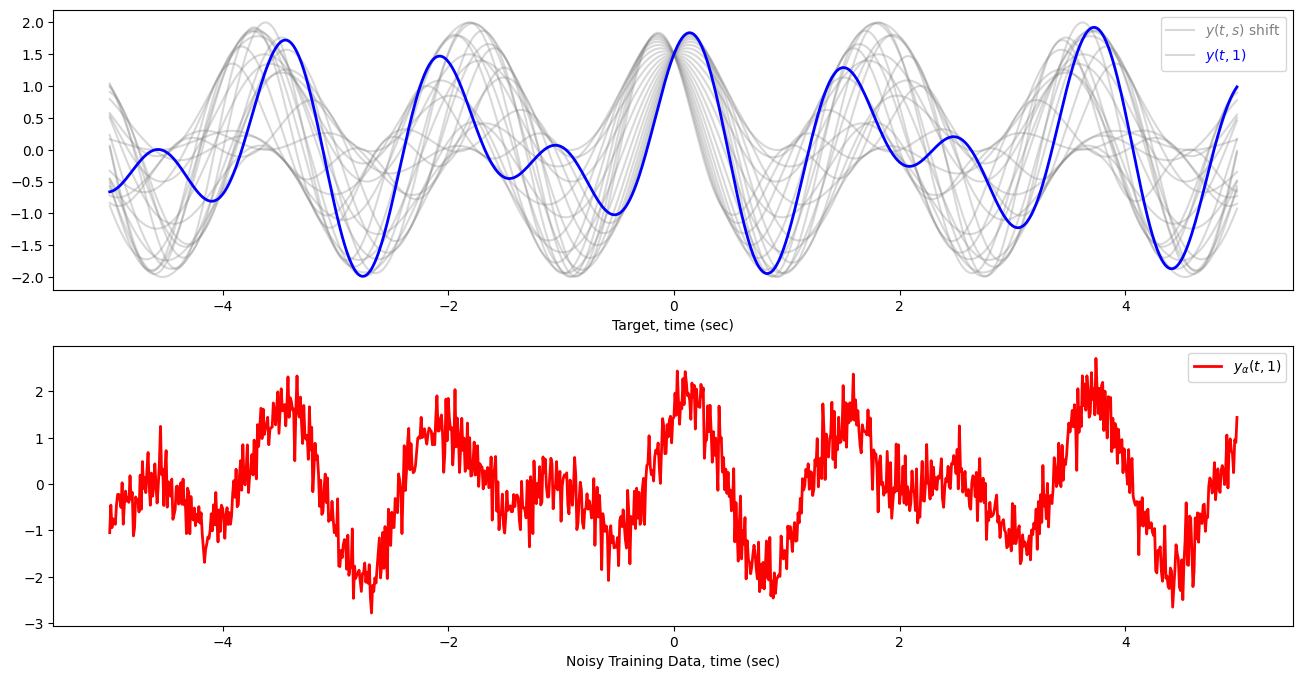

In [9]:
## SOLUTION REQUIRED IN THIS BLOCK ##

## Plotting simulated functional data

t_line = np.arange(-5., 5., 1/100.) # line space
alpha = 0.4
## Creating a function to produce cyclical y data.
y_func = lambda s: np.sin(np.sin(s) * 2 * np.pi * t_line + np.pi/6) + np.cos(2 * np.sqrt(3) * t_line)
y = y_func(1)
## Adding noise
y_noisy = y + np.random.normal(0, 1, len(y)) * alpha


## Plotting
fig, ax = plt.subplots(2,1, figsize=(16,8))
fval = np.arange(-1,1,0.1)

for i in fval:
    ax[0].plot(t_line, y_func(i), color='gray', alpha=.3,label="$sin(f)$ shift")

ax[0].plot(t_line, y, lw = 2,label = "fixed $f$",color="b")
ax[0].set_xlabel('Target, time (sec)')
ax[1].plot(t_line, y_noisy, lw = 2,c="r")
ax[1].set_xlabel('Noisy Training Data, time (sec)')
ax[0].legend(["$y(t,s)$ shift","$y(t,1)$"],labelcolor=["gray","b"])
ax[1].legend(["$y_{\\alpha}(t,1)$"])

In the figure above we can see the true output of the generating function, given a specific value of $s$ (blue), and various drifts according to different values of $s$ (gray).  In the bottom plot you can see the noisy data (training),  matching the blue graph in the top plot.

### Creating PyTorch RNN model

Here we create a basic PyTorch RNN class (inherits from `nn.Module`).  

* *input_size* – The number of expected features (dimensions) in the input t

* *hidden_size* – The number of features in the hidden state h

* *num_layers* – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two RNNs together to form a stacked RNN, with the second RNN taking in outputs of the first RNN and computing the final results.    

* batch_first – If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Note that this does not apply to hidden or cell states.




For more information, please check the
[PyTorch nn.RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN) documentation.


In [10]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()

        self.hidden_dim=hidden_dim

        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)

        # Adding a fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)

        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        r_out = r_out.view(-1, self.hidden_dim)

        # get final output
        output = self.fc(r_out)

        return output, hidden


In [11]:

# RNN Hyperparameters
input_size=1 # our data is 1-dim
output_size=1
hidden_dim=16
n_layers=2

# instantiate an RNN model
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 16, num_layers=2, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)


### RNN Training

Now we need to define a training function that takes the following hyper-parameters:  

* rnn : the RNN model object
* n_steps = on how many steps ($t$) to train the model (equivalent to "epochs").
* lag = the steps/datapoints lag between the training and target data.
* alpha = how much noise to add to the training data
* seq_length = how many datapoints  (time-series steps) to consider in each "epoch": $(t-k:t)$
* stride = the window size of the function (of which the seq_length will be divided).
* print_every = how often (in steps) to print a plot of the prediction against the target.

At each step, we have a lagged value of x, noisy lagged value of x (training), and a value of y (target not lagged).

P3Q2:  (5pts)

Fill out the missing code according to the function definition above

In [12]:
## SOLUTION REQUIRED IN THIS BLOCK##

# As above, creating a simulated data generator from our function (not noisy)
# this time, the function should depend on "step" as well (x_line is ever changing).

y_func = lambda step, s: np.sin(np.sin(s) * 2 * np.pi * step + np.pi/6) + np.cos(2 * np.sqrt(3) * step)



In [15]:
# train the RNN
def train(rnn,y_func, n_steps, print_every,stride,seq_length,
          alpha,lag):
    # initialize the RNN hidden state
    hidden = None
    s = 1 # initialize f
    for batch_i, step in enumerate(range(n_steps)):
        # defining the training data

        # t_line = np.linspace(y_func(s,step),y_func(s,step)+stride,seq_length+stride)
        t_line =  np.linspace(step,step+stride, seq_length)
        data = y_func(s,t_line)
        noisy_data =  data + np.random.randn(len(t_line))*alpha
        # update f
        s += 0.05

        # prepare data for training
        data.resize((seq_length , 1)) # input_size=1
        noisy_data.resize((seq_length , 1)) # input_size=1
        # creating a lag in the noisy data aginst y
        x = noisy_data[:-lag]
        y = data[lag:]

        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # zero out gradients
        optimizer.zero_grad()
        # calculate backprop and update weights
        loss.backward()
        optimizer.step()

        # plot loss and predictions
        if batch_i%print_every == 0:
            plt.plot(t_line[lag:], x, 'r.',label = "training")
            plt.plot(t_line[lag:], y, 'b.',label = "actual")
            plt.plot(t_line[lag:], prediction.data.numpy().flatten(), 'y.',label= "prediction") #
            plt.title("Loss: {:,}".format(loss.item()))
            plt.legend(loc="upper left")
            plt.show()

    return rnn

# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)

    
Train the RNN model on various hyper-parameters (defined below) and review the results.   


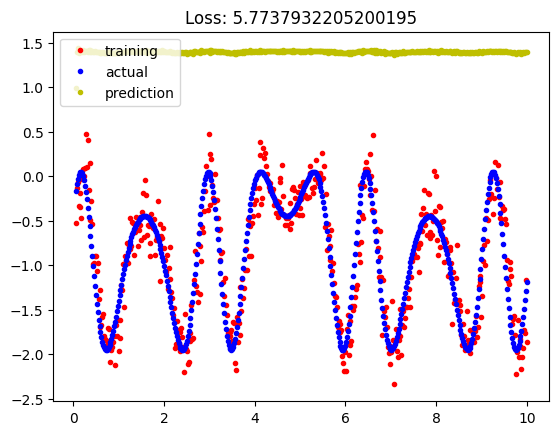

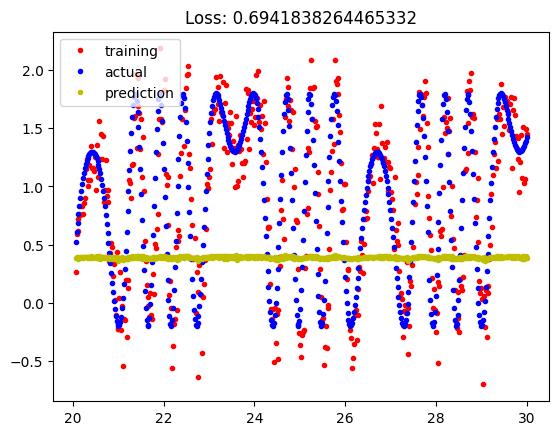

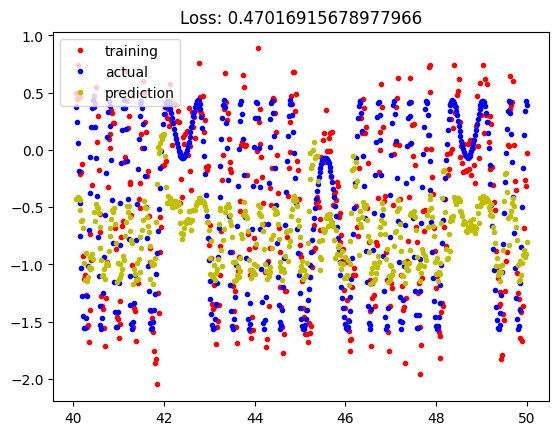

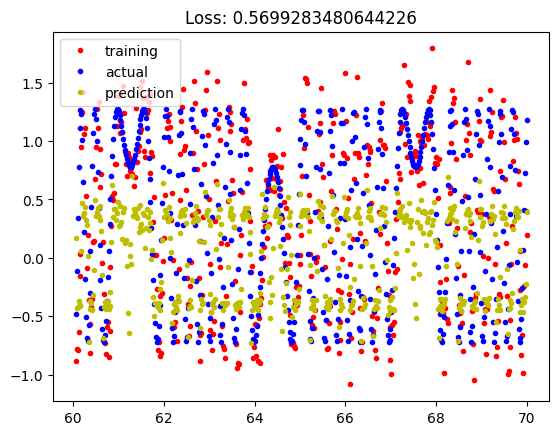

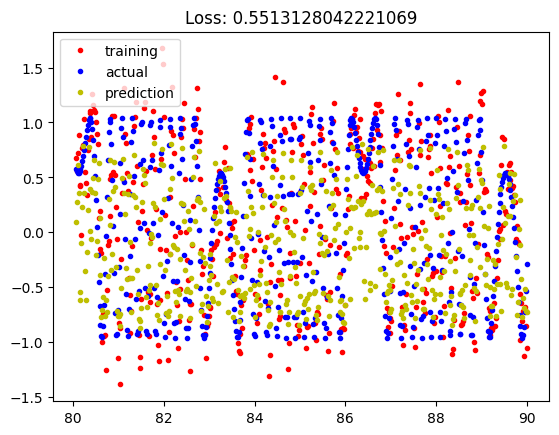

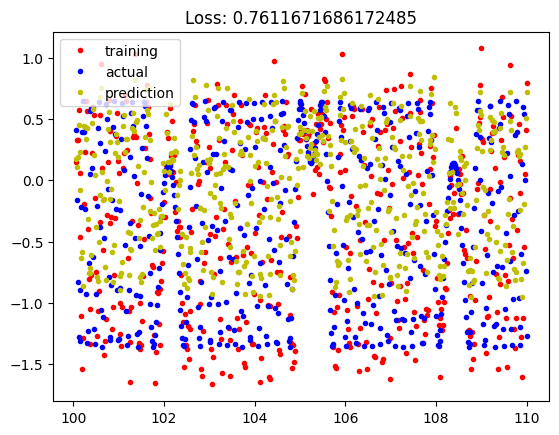

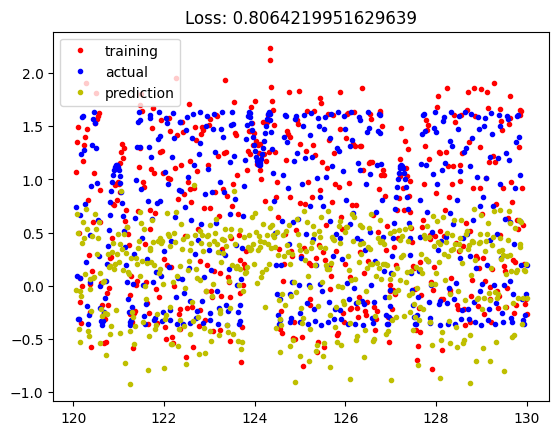

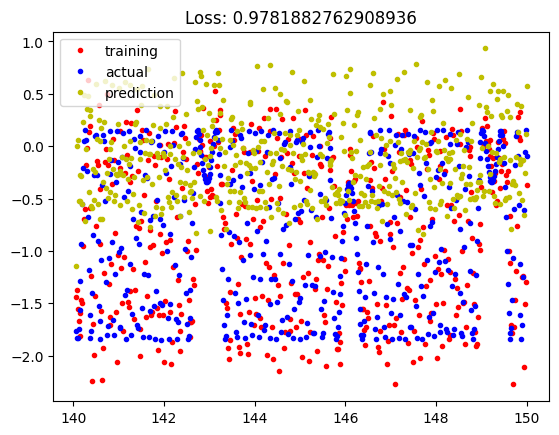

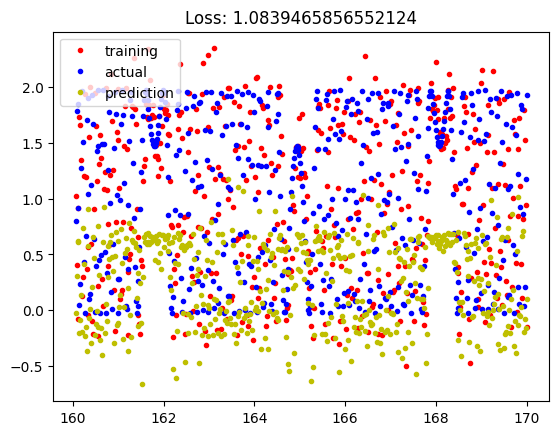

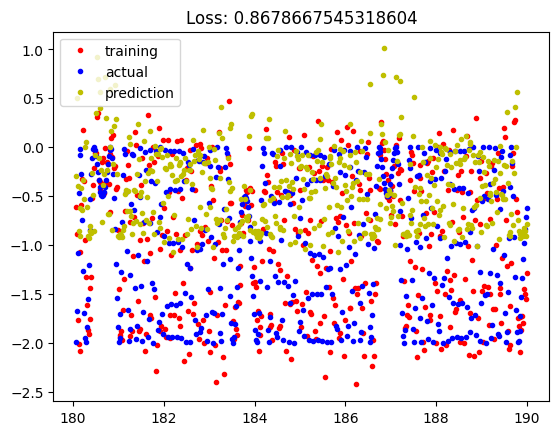

In [16]:

# train the rnn and monitor results

n_steps = 200
stride = 10
lag = 3
alpha = 0.2
seq_length = 500
print_every = 20

trained_rnn = train(rnn, y_func,  n_steps, print_every,
                    stride,seq_length,alpha,lag)

P3Q3: (10pts)

(a) Do you think our model performs well?     
(b) Write about the relationships and interplay between the different hyper-parameters, and explain how they effect the RNN model. Please relate also to the RNN architecture in our solution.

(c) Can you give a real world example where this type of model can be applied?   
(d) What would you change to improve it?

Write your solution here!

## P3Q3: RNN Model Analysis

**(a) Model Performance**

The model is BAD!. The predictions (yellow) are basically flat around 1.0-1.5 while the actual data (blue) oscillates between -0.5 and 2.0. It learned to output the mean instead of the pattern. Loss of 0.142 confirms it's not working.

**(b) Hyperparameter Relationships**

seq_length needs to cover at least one full cycle of the oscillation or the model can't learn the pattern. With lag creating the prediction horizon, larger values make prediction harder. Our 16 hidden units across 2 layers is probably too small for this complex function with multiple frequencies.

The parameters work together: if seq_length is too short, adding more hidden units won't help. Too much noise (alpha) hides the pattern, but some noise prevents overfitting. Stride controls training sample overlap, affecting how diverse the training batches are.

**(c) Real World Example**

Electricity demand forecasting. Power usage has daily cycles (business hours vs nights), weekly patterns (weekdays vs weekends), plus weather randomness, stock market prices. Basically, many kinds of time series that should learn types of trends and seasonality in the dataset.

**(d) Improvements**

Switch to LSTM/GRU for better long sequence handling. Bump hidden_dim to 64 or 128. Make seq_length at least 2x the oscillation period. Add learning rate decay since loss plateaus. Maybe try attention mechanisms to focus on important time steps. Could also difference the data first to make it stationary.

THE END!